In [115]:
import os
import csv
import numpy as np
import random
from random import shuffle
import math
import pandas as pd
from random import uniform
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


filename = '../input/USERS.json'
filename1 = '../input/EVENTS.json'
filename2 = '../input/MESSAGES.json'


In [116]:
users = pd.read_json(filename)
events = pd.read_json(filename1)
messages = pd.read_json(filename2)

In [117]:
users.head()

,_id,age,challenge,churnedAfterSix,gender,goalsAspiration,height,motivation,trigger,weight
0,{'$oid': '5a2e417806d240124a6185a0'},25,motivation,NA,F,medium,156.2,looks,tired,99.3
1,{'$oid': '5a434efac3a72a107ce35c25'},66,motivation,False,F,high,154.9,health,emotions,60.3
2,{'$oid': '5a4feb9c0fb3cc7e95f244b8'},61,motivation,False,F,medium,174.0,control,social,65.8
3,{'$oid': '5a5b956b86ef893f9f93799a'},55,motivation,False,F,medium,172.7,health,emotions,80.7
4,{'$oid': '5a75a465eab9185480e42453'},61,motivation,True,F,medium,162.6,looks,emotions,98.9


In [118]:
messages.head()

,_id,emojisUsed,mentionedScales,mentionedTracker,messageType,questionsAsked,sentiment,user,weekNumber
0,{'$oid': '5ce7146a443e670e3c162086'},0.0,0.0,0.0,group,0.0,1.026933,{'$oid': '5a2e417806d240124a6185a0'},0
1,{'$oid': '5ce9b6fe443e670e3c1722c9'},0.0,0.0,0.0,group,0.0,0.295621,{'$oid': '5a2e417806d240124a6185a0'},0
2,{'$oid': '5ce9b7b5443e670e3c1722d5'},0.0,0.0,0.0,group,0.0,0.069245,{'$oid': '5a2e417806d240124a6185a0'},0
3,{'$oid': '5d032f844c772721eb101042'},0.0,0.0,0.0,private,0.0,0.141559,{'$oid': '5a2e417806d240124a6185a0'},3
4,{'$oid': '5d03c2144c772721eb104ee1'},0.0,0.0,0.0,private,0.0,0.109137,{'$oid': '5a2e417806d240124a6185a0'},3


In [119]:
events.head()

,_id,title,user,weekOnProgramme
0,{'$oid': '5ce29cff689a6012af3c1f57'},Added new food diary entry,{'$oid': '5a2e417806d240124a6185a0'},0
1,{'$oid': '5ce7146a443e670e3c162087'},Sent message,{'$oid': '5a2e417806d240124a6185a0'},0
2,{'$oid': '5ce9b6fe443e670e3c1722ca'},Sent message,{'$oid': '5a2e417806d240124a6185a0'},0
3,{'$oid': '5ce9b7b5443e670e3c1722d6'},Sent message,{'$oid': '5a2e417806d240124a6185a0'},0
4,{'$oid': '5ceb805a7642fb12bc1e9c55'},Read article,{'$oid': '5a2e417806d240124a6185a0'},1


In [120]:
messages['stripped'] = messages['user'].apply(lambda x: str(x['$oid'])) #convert user ID in messages to string
messages.stripped = messages.stripped.astype(str)
messages['stripped'] = messages['stripped'].str.strip()

Create 6 aggregate features from all messages corresponding with each particular user

In [122]:
avgSent = messages.groupby(['stripped'])['sentiment'].mean()  #average sentiment of each user's messages
avgEmoji = messages.groupby(['stripped'])['emojisUsed'].mean() #average number of emojis used in each user's messages
totalQuest = messages.groupby(['stripped'])['questionsAsked'].sum() #total questions asked by each user
scaleCount = messages.groupby(['stripped'])['mentionedScales'].sum() #total number of scale mentions by each user
trackCount = messages.groupby(['stripped'])['mentionedTracker'].sum() #total number of tracker mentions by each user
mType = messages.groupby('stripped')['messageType'].value_counts().unstack().fillna(0) #get total number of private messages and total number of group messages for each user

concatenate each of new aggregate message features into new conjMessages dataframe

In [123]:
conjMessages = pd.concat([avgSent,avgEmoji, totalQuest, scaleCount, trackCount, mType], axis=1).reset_index()

In [124]:
conjMessages.head()

,stripped,sentiment,emojisUsed,questionsAsked,mentionedScales,mentionedTracker,group,private
0,5a2e417806d240124a6185a0,0.328499,0.000000,0.0,0.0,0.0,3.0,2.0
1,5a434efac3a72a107ce35c25,0.198975,0.000000,1.0,1.0,0.0,18.0,10.0
2,5a4feb9c0fb3cc7e95f244b8,0.038765,0.021739,8.0,2.0,0.0,43.0,5.0
3,5a5b956b86ef893f9f93799a,0.137963,0.000000,6.0,1.0,2.0,29.0,16.0
4,5a75a465eab9185480e42453,0.174618,0.040000,4.0,0.0,0.0,45.0,8.0


In [125]:
events = events[events.title != 'Sent message'] #for events, remove sent message events (as covered by messages dataframe)

In [126]:
events['stripped'] = events['user'].apply(lambda x: str(x['$oid'])) #convert user ID in events to string
events.stripped = events.stripped.astype(str)
events['stripped'] = events['stripped'].str.strip()

create new dataframe of aggregate count of each event type for each user (barring message events)

In [129]:
eventsConj = events.groupby('stripped')['title'].value_counts().unstack().fillna(0) 
eventsConj = eventsConj.reset_index()

In [130]:
eventsConj.head()

title,stripped,Added new food diary entry,Read article,Saved recipe,Weigh-in
0,5a2e417806d240124a6185a0,2.0,24.0,0.0,7.0
1,5a434efac3a72a107ce35c25,0.0,5.0,0.0,6.0
2,5a4feb9c0fb3cc7e95f244b8,1.0,29.0,0.0,20.0
3,5a5b956b86ef893f9f93799a,115.0,46.0,5.0,12.0
4,5a75a465eab9185480e42453,48.0,36.0,0.0,24.0


In [131]:
users['stripped'] = users['_id'].apply(lambda x: str(x['$oid'])) #convert user ID in users to string
users['stripped'] = users['stripped'].str.strip()
users = users.drop(['_id'], axis=1)

join the 3 dataframes

In [134]:
fTable = pd.merge(eventsConj, conjMessages, left_on='stripped', right_on='stripped') #inner join eventsConj and conjMessages dataframes

In [136]:
features = pd.merge(fTable, users, left_on='stripped', right_on='stripped') #inner join users dataframe with fTable

In [138]:
features['goalsAspiration'].fillna("", inplace=True) #replace NaN vals in categorical cols with ''
features['challenge'].fillna("", inplace=True)

In [140]:
features[["churnedAfterSix"]] *= 1  #convert boolean string to int equivalent

In [141]:
features.head()

,stripped,Added new food diary entry,Read article,Saved recipe,Weigh-in,sentiment,emojisUsed,questionsAsked,mentionedScales,mentionedTracker,...,private,age,challenge,churnedAfterSix,gender,goalsAspiration,height,motivation,trigger,weight
0,5a2e417806d240124a6185a0,2.0,24.0,0.0,7.0,0.328499,0.000000,0.0,0.0,0.0,...,2.0,25,motivation,NA,F,medium,156.2,looks,tired,99.3
1,5a434efac3a72a107ce35c25,0.0,5.0,0.0,6.0,0.198975,0.000000,1.0,1.0,0.0,...,10.0,66,motivation,0,F,high,154.9,health,emotions,60.3
2,5a4feb9c0fb3cc7e95f244b8,1.0,29.0,0.0,20.0,0.038765,0.021739,8.0,2.0,0.0,...,5.0,61,motivation,0,F,medium,174.0,control,social,65.8
3,5a5b956b86ef893f9f93799a,115.0,46.0,5.0,12.0,0.137963,0.000000,6.0,1.0,2.0,...,16.0,55,motivation,0,F,medium,172.7,health,emotions,80.7
4,5a75a465eab9185480e42453,48.0,36.0,0.0,24.0,0.174618,0.040000,4.0,0.0,0.0,...,8.0,61,motivation,1,F,medium,162.6,looks,emotions,98.9


In [143]:
trainSet = features.loc[features['churnedAfterSix'] != 'NA'] #partition training data and test data
testSet = features.loc[features['churnedAfterSix'] == 'NA']

In [144]:
len(trainSet[trainSet["churnedAfterSix"]==1])

36

In [145]:
len(trainSet[trainSet["churnedAfterSix"]==0])

366

within training data, there are a large number of negative churnedAfterSix labels, with very few positive examples i.e. highly imbalanced. Therefore ROC-AUC metric is used during training

In [146]:
trainSet.head()

,stripped,Added new food diary entry,Read article,Saved recipe,Weigh-in,sentiment,emojisUsed,questionsAsked,mentionedScales,mentionedTracker,...,private,age,challenge,churnedAfterSix,gender,goalsAspiration,height,motivation,trigger,weight
1,5a434efac3a72a107ce35c25,0.0,5.0,0.0,6.0,0.198975,0.000000,1.0,1.0,0.0,...,10.0,66,motivation,0,F,high,154.9,health,emotions,60.3
2,5a4feb9c0fb3cc7e95f244b8,1.0,29.0,0.0,20.0,0.038765,0.021739,8.0,2.0,0.0,...,5.0,61,motivation,0,F,medium,174.0,control,social,65.8
3,5a5b956b86ef893f9f93799a,115.0,46.0,5.0,12.0,0.137963,0.000000,6.0,1.0,2.0,...,16.0,55,motivation,0,F,medium,172.7,health,emotions,80.7
4,5a75a465eab9185480e42453,48.0,36.0,0.0,24.0,0.174618,0.040000,4.0,0.0,0.0,...,8.0,61,motivation,1,F,medium,162.6,looks,emotions,98.9
5,5aa6d1995d2b4437b66358f1,29.0,35.0,1.0,90.0,0.128487,0.333333,0.0,5.0,0.0,...,20.0,46,motivation,0,F,medium,198.1,health,stress,91.2


In [147]:
trainSet = trainSet.drop(['stripped'], axis=1)

In [148]:
#denote categorical features
cols = set(['challenge','gender','goalsAspiration','motivation','trigger'])

for col in cols:
            trainSet[col] = trainSet[col].astype('category')
            testSet[col] = testSet[col].astype('category')
            

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [149]:
#create training set and validation set to use during training. 80:20 split used.
Y = trainSet['churnedAfterSix']
X = trainSet.drop(['churnedAfterSix'], axis=1)
x, x_val, y, y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model makes use lightgbm gradient boosted trees

In [150]:
import lightgbm as lightgbm

categorical_features = [c for c, col in enumerate(X.columns) if col in cols]
train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
test_data = lightgbm.Dataset(x_val, label=y_val)




parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc', #auc
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31, #31
    'feature_fraction': 0.31, #0.31
    'bagging_fraction': 0.5,
    'bagging_freq': 20, #20
    'learning_rate': 0.002,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=300)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [12, 13, 14, 16, 17]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's auc: 0.598456
Training until validation scores don't improve for 300 rounds.
[2]	valid_0's auc: 0.689189
[3]	valid_0's auc: 0.683398
[4]	valid_0's auc: 0.589768
[5]	valid_0's auc: 0.685328
[6]	valid_0's auc: 0.629344
[7]	valid_0's auc: 0.619691
[8]	valid_0's auc: 0.581081
[9]	valid_0's auc: 0.584942
[10]	valid_0's auc: 0.600386
[11]	valid_0's auc: 0.586873
[12]	valid_0's auc: 0.583012
[13]	valid_0's auc: 0.588803
[14]	valid_0's auc: 0.567568
[15]	valid_0's auc: 0.544402
[16]	valid_0's auc: 0.530888
[17]	valid_0's auc: 0.515444
[18]	valid_0's auc: 0.519305
[19]	valid_0's auc: 0.546332
[20]	valid_0's auc: 0.561776
[21]	valid_0's auc: 0.550193
[22]	valid_0's auc: 0.561776
[23]	valid_0's auc: 0.557915
[24]	valid_0's auc: 0.53861
[25]	valid_0's auc: 0.515444
[26]	valid_0's auc: 0.515444
[27]	valid_0's auc: 0.490347
[28]	valid_0's auc: 0.472973
[29]	valid_0's auc: 0.476834
[30]	valid_0's auc: 0.467181
[31]	valid_0's auc: 0.459459
[32]	valid_0's auc: 0.455598
[33]	valid_0's auc:

best model has AUC score of 0.689

Plotting feature importances...


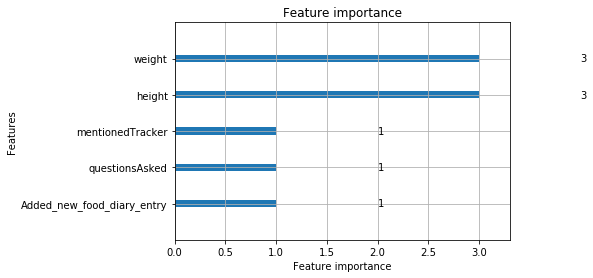

In [151]:
import matplotlib.pyplot as plt
print('Plotting feature importances...')
ax = lightgbm.plot_importance(model, max_num_features=19)
plt.show()

The 5 features that have the greatest importance in determining user churn are: user weight; user height; the number of times the user mentions the tracker; the number of questions they ask; and how many times they add new entries to the food diary.

In [152]:
testSetIDs = testSet['stripped'].reset_index(drop=True)
testSet = testSet.drop(['stripped', 'churnedAfterSix'], axis=1)

In [155]:
pred = model.predict(testSet, num_iteration=model.best_iteration) #predict prob of churn for 10 users in test set
churnedAfterSixProb = pd.Series(pred) 

In [163]:
result = pd.concat([testSetIDs, churnedAfterSixProb], axis=1)
result.columns = ['userID', 'churnedAfterSixProbability']

In [164]:
result

,userID,churnedAfterSixProbability
0,5a2e417806d240124a6185a0,0.092688
1,5ca8f158540a036b663a34df,0.091620
2,5cba40489203684bd4c4e04f,0.092677
3,5cbc31e194b8d6115731aed9,0.091785
4,5cc929eba4cedc162e6df3c2,0.091421
5,5cd520832925a912cbdd6061,0.091874
6,5cd69b69fb622f12c5a74008,0.092039
7,5cd976930b932012b968558e,0.092039
8,5ce050278ff304131108e204,0.091169


the probabilites of each user churning. Each is low (expected given very low frequency of user churn, however there are differences, suggesting some at more risk of churn than others)